# Field line tracing

Here is some starter code to set up field line tracing in Python.

## Homework Part 1 (getting things set up -- part 2 to follow later)

* Set up an environment where you can run Python code and generate plots (My preference would be a single Jupyter notebook, but it is fine to instead have a regular Python script that generates plots, in which case, those plots should be part of your submission -- e.g., attach PNGs).

* Get the code below (or something equivalent) to run. Copy&paste is fine.

* Review the `trace_field_line()` function and explain how it works.

* Add more seed points to improve the visualization of the dipole field.

* Submit your code and the generated plots.

In [99]:
# import the basic libraries we'll use
# Note: This could be done without pandas, but it makes things a bit neater, since
# we can store not just columns of numbers, but also what they mean.

import numpy as np
import pandas as pd
import scipy.integrate

In [100]:
# Here are some sample magnetic fields
#
# The code expects a function B(t, x) that takes a time t and a position x
# (a length-3 numpy array) and returns the magnetic field B at that point
# (also a length-3 numpy array).

def B_uniform(t, x):
    return np.array([0., 0., 1.])  # uniform B field in z direction

def B_dipole(t, x):
    m = np.array([0., 0., 1.])  # magnetic moment
    # dipole field formula
    return 3*x*np.dot(x, m) / np.linalg.norm(x)**5 - m / np.linalg.norm(x)**3


# Integrand of Biot Savart for Ring centered at 0, 0, 0
def ring_integrand(theta, x, R):
    # dl hat = theta hat = -sin(theta)x^hat + cos(theta)y^hat
    dl_hat = np.array([-np.sin(theta), np.cos(theta), 0])
    l_vec = np.array([R*np.cos(theta), R*np.sin(theta), 0])

    return np.cross(dl_hat, (l_vec-x)) / (np.linalg.norm(l_vec - x) ** 3)

def B_circle_current(t, x):
    R = 0.1
    I = 1

    x0, y0, z0 = x[0], x[1], x[2]

    result, error = scipy.integrate.quad_vec(lambda theta: ring_integrand(theta, x, R), 0, 2*np.pi)

    return I/(4*np.pi)* result 

    # Ring is on xy plane

def B_monopole(t, x):
    r = np.linalg.norm(x)

    return 1/(r**3) * x

In [101]:
def trace_field_line(r0, get_B, r_min=0.5, r_max=10.0):
    """Trace a magnetic field line starting at position r0 in the field
     provided by the get_B function.

     This function integrates the field line in the positive direction
     until it get either closer than `r_min` to the origin, or outside of `r_max`.
     
     Returns a pandas DataFrame with columns 'time', 'x', 'y', 'z'.
     """
    def rhs(t, x):
        B = get_B(t, x)
        B /= np.linalg.norm(B)
        return B
    
    def outside(t, x):
        return np.linalg.norm(x) - r_max  # stop if r > r_max
    outside.terminal = True
    outside.direction = 1  # only trigger when approaching from inside

    def inside(t, x):
        return np.linalg.norm(x) - r_min  # stop if r < r_min
    inside.terminal = True
    inside.direction = -1  # only trigger when approaching from outside
        
    t = (0., 20.) # integrate up to time 20 -- That's kinda arbitrary, but usually is long enough
    sol = scipy.integrate.solve_ivp(rhs, t, r0, events=[outside, inside], max_step = .2)
    df = pd.DataFrame(np.column_stack((sol.t, sol.y.T)), columns=['time', 'x', 'y', 'z'])
    return df

def trace_field_lines(seeds, B_func, integrate_kwargs):
    """Trace multiple field lines.
    
    This is a convenience wrapper around trace_field_line.
    `seeds` is a list of starting positions.
    `B_func` is the magnetic field function.
    `integrate_kwargs` is a dictionary of additional keyword arguments to pass to
    `trace_field_line`.
    
    Returns a list of pandas DataFrames, one per seed point."""
    return [trace_field_line(r0, B_func, **integrate_kwargs) for r0 in seeds]

In [102]:
# Pick a bunch of seed points and trace field lines

theta = np.pi / 8
seeds = [np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)]) 
        for phi in np.linspace(0., 2.*np.pi, 100, endpoint=False)]

dfs = trace_field_lines(seeds, B_monopole, integrate_kwargs={"r_min": 0.2, "r_max": 10.0})

In [103]:
dfs[0][:5]  # show the first traced field line as an example of what a numerically traced field line looks like

,time,x,y,z
0,0.000000,0.382683,0.0,0.923880
1,0.104176,0.422550,0.0,1.020126
2,0.304176,0.499087,0.0,1.204902
3,0.504176,0.575623,0.0,1.389678
4,0.704176,0.652160,0.0,1.574454


In [104]:
# Here are helpers to use pyvista to visualize the traced field lines
# If you don't have / don't like pyvista, you can use matplotlib or whatever you prefer (see also below)

import pyvista as pv

def to_mesh_lines(df):
    positions = df[['x', 'y', 'z']].values
    mesh = pv.PolyData(positions)
    lines = pv.lines_from_points(positions)
    return mesh, lines

def plot_lp(plotter, df, lines_only=False):
    mesh, lines = to_mesh_lines(df)
    plotter.add_mesh(lines, line_width=1, color='blue')
    if not lines_only:
        #plotter.add_mesh(mesh, point_size=5.0, color='blue', render_points_as_spheres=True)
        plotter.add_mesh(mesh, point_size=5.0, scalars=df['time'], cmap='jet', render_points_as_spheres=True)

def plot_field_lines(plotter, dfs):
    for df in dfs:
        plot_lp(plotter, df)


In [105]:
# Make it so that the pyvista plot shows up in the notebook on github -- comment this out for interactive use
#pv.set_jupyter_backend('static')

#p = pv.Plotter()
#plot_field_lines(p, dfs)
#p.show()

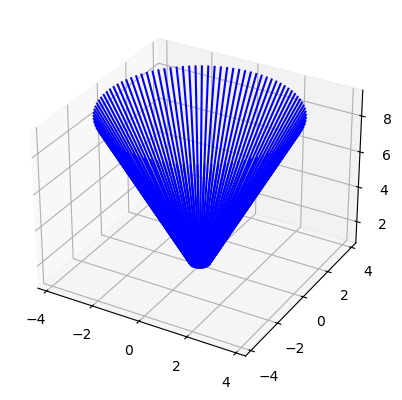

In [106]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for df in dfs:
    ax.plot(df['x'], df['y'], df['z'], color='blue')


In [107]:
# Savefig
fig.savefig("HW3Output/B_monopole.png")